参考: 
- https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 使用 3d 图必须要先 import Axes3D

%load_ext autoreload
%autoreload 2

## VNet loss-weight curve

In [2]:
def vis_loss_weight_map(curve_data_path, step=1):
    curves_data = np.load(curve_data_path).squeeze()  # (100, 2, 100)

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('loss')
    # ax.set_ylabel('epoch')
    ax.set_yticks([])
    ax.set_zlabel('weight')
    # ax.set_title('mw_cifar10_imb100')
    ax.view_init(0, -90)  # vertical,horizontal

    for i in range(len(curves_data)):
        if i % step == 0:
            x = curves_data[i][0]
            z = curves_data[i][1]
            y = np.array([i] * len(x))
            ax.plot3D(x, y, z)
            ax.text(x[99], y[99], z[99], f'{i+1}', 
                    color='gray', 
                    fontdict={
#                         'fontweight': 'bold',
                        'size': 9
                    })

<IPython.core.display.Javascript object>


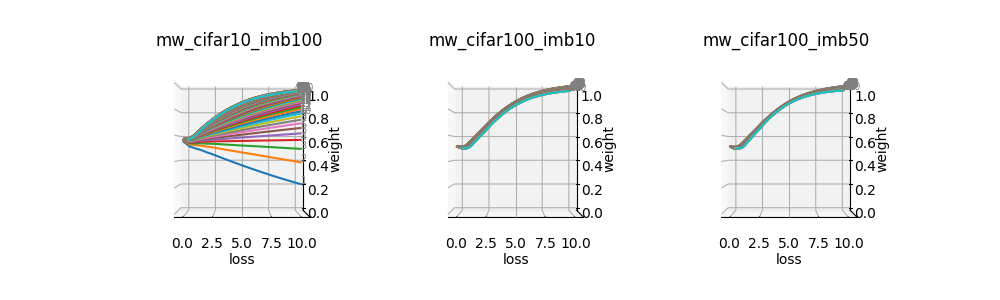

In [4]:
import os

%matplotlib notebook
# viewing figures interactively rather than statically in the notebook

curves_dir = 'npy'
# curves = os.listdir(curves_dir)
curves = [  # 自定义顺序
    'mw_cifar10_imb100_curves_data.npy',
    'mw_cifar100_imb10_curves_data.npy',
    'mw_cifar100_imb50_curves_data.npy'
]
curves_num = len(curves)

cols = 3  # 每行作图个数
rows = curves_num // cols + 1 if curves_num % cols > 0 else curves_num // cols

f, axs = plt.subplots(nrows=rows, ncols=cols,
                      # sharex=True,
                      subplot_kw=dict(projection='3d'))  # 指定子图为3D
f.set_size_inches((10, rows * 3))  # w,h

for idx, cur in enumerate(curves):
    curve_path = os.path.join(curves_dir, cur)
    curves_data = np.load(curve_path).squeeze()  # (100, 2, 100)

    ax = axs.flat[idx]

    if idx < curves_num:
        ax.set_xlabel('loss')
#         ax.set_ylabel('epoch')
        ax.set_yticks([])
        ax.set_zlabel('weight')
        ax.set_zlim(0,1)
        ax.set_title(cur.replace('_curves_data.npy', ''))  # 去掉后缀
        ax.view_init(0, -90)

        step = 1

        for i in range(len(curves_data)):
            if i % step == 0:
                x = curves_data[i][0]
                z = curves_data[i][1]
                y = np.array([i] * len(x))
                ax.plot3D(x, y, z)
                ax.text(x[99], y[99], z[99], f'{i + 1}', color='gray', fontdict={'size': 7})
    else:
        ax.clean()
        
plt.show()

<IPython.core.display.Javascript object>


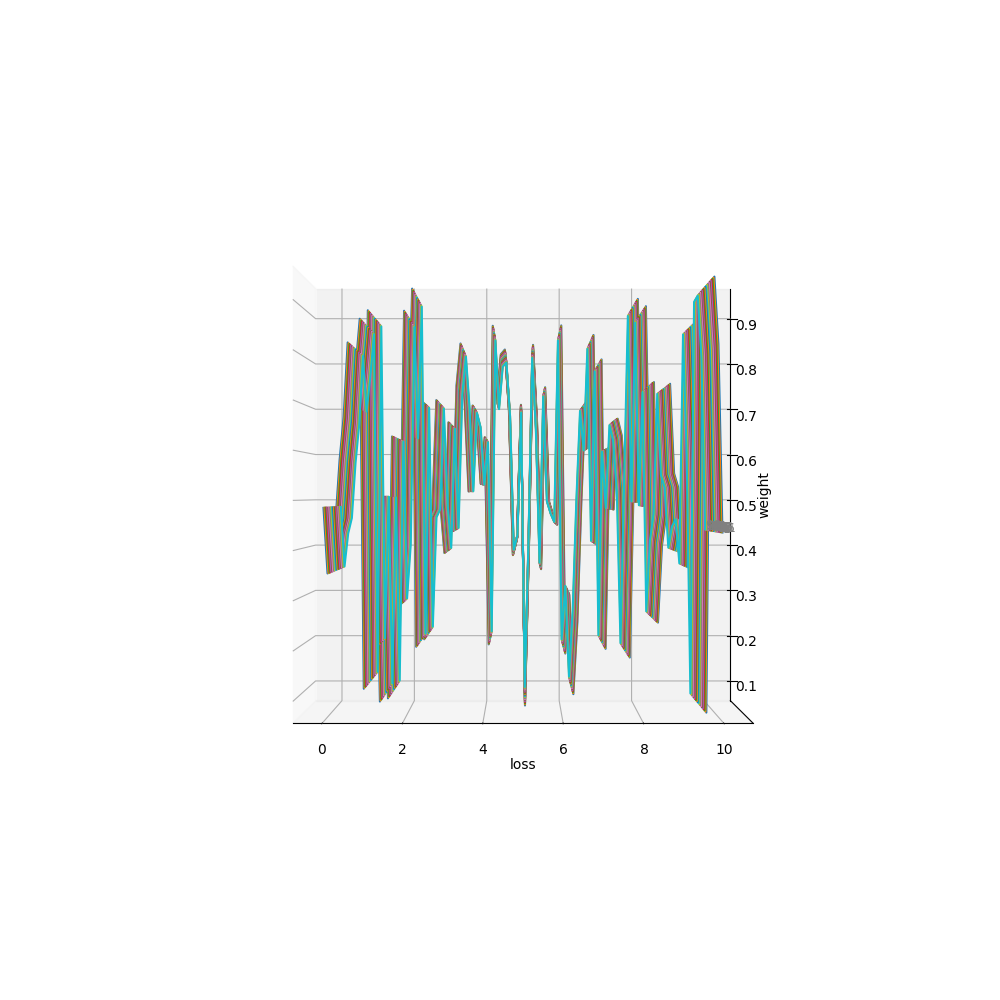

In [5]:
# vis_loss_weight_map('npy/mw_cifar10_imb100_curves_data.npy')
# vis_loss_weight_map('npy/mw_cifar100_imb10_curves_data.npy')
vis_loss_weight_map('npy/mw_v2_cifar10_imb100_curves_data.npy', step=5)  # batch vnet
# vis_loss_weight_map('npy/mw_v2_cifar10_imb10_curves_data.npy', step=5)  # batch vnet

## VNet v2
- batch_loss → batch_weights, consider the sample relations in a batch
- use a batch samples, plot the loss-weight scatter/curve

### build dataloader

In [8]:
from dataset.data_utils import get_imb_meta_test_datasets
from torch.utils.data import DataLoader
import random

random.seed(42)
imb_train_dataset, meta_train_dataset, test_dataset = get_imb_meta_test_datasets(
    dataset='cifar10', num_classes=10, num_meta=10, imb_factor=100
)

imbalanced_train_loader = DataLoader(imb_train_dataset, batch_size=100, drop_last=True, shuffle=True)
valid_loader = DataLoader(meta_train_dataset, batch_size=100, drop_last=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

print(len(imbalanced_train_loader))  # 1211
print(len(valid_loader))
print(len(test_loader))  # 10000

Files already downloaded and verified
[13660, 18905, 48891, 15288, 46678, 9533, 4337, 3842, 2967, 7311, 20114, 3779, 41472, 1006, 7297, 37418, 29522, 48669, 6241, 15756, 13567, 9151, 32257, 4526, 25743, 9150, 43513, 41834, 2076, 22594, 13602, 25899, 39910, 20329, 36946, 43237, 46503, 39300, 23295, 9710, 36671, 27491, 34229, 24454, 15126, 26653, 48884, 1203, 37530, 49687, 1355, 42177, 27387, 33125, 44676, 33035, 25205, 37360, 44337, 17055, 42380, 22534, 25223, 28395, 22836, 361, 23036, 41106, 37822, 43027, 45817, 25791, 5809, 22772, 22069, 41526, 26031, 36429, 31746, 10583, 47119, 8574, 21671, 26608, 716, 22409, 42371, 5373, 11673, 3625, 15588, 41630, 33784, 18488, 49779, 30420, 32096, 23861, 29238, 8587]
imb_img_num: [4990, 2991, 1793, 1075, 644, 386, 231, 138, 83, 49]
imb_train_dataset: 12380
meta_train_dataset: 100
test_dataset: 10000
123
1
100


### load VNet_v2 model

In [9]:
from net.vnet import VNet
from net.resnet import build_model
from utils import load_model

# load trained vnet & classifier
vnet = VNet(100, 300, 100).cuda()
vnet = load_model(vnet, ckpt_path='output/mw_v2_cifar10_imb100_Mar10_132504/vnet_epoch_89.pth')
vnet.eval()

model = build_model('cifar10').cuda()
model = load_model(model, ckpt_path='output/mw_v2_cifar10_imb100_Mar10_132504/rs32_epoch_89.pth')
model.eval()

print('load model done!')

load output/mw_v2_cifar10_imb100_Mar10_132504/vnet_epoch_89.pth, epoch 89, acc: 74.53
load output/mw_v2_cifar10_imb100_Mar10_132504/rs32_epoch_89.pth, epoch 89, acc: 74.53
load model done!


### plot loss-weight scatter for a batch samples from `imbalanced_train_loader`

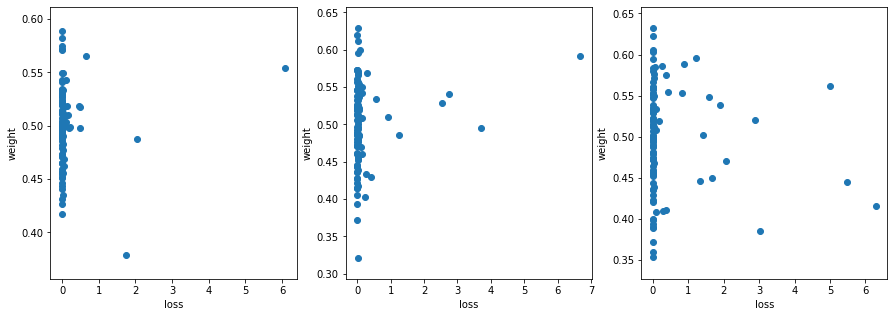

In [21]:
import torch
import torch.nn.functional as F
from utils import to_var, to_numpy
import matplotlib.pyplot as plt 

%matplotlib inline

f, axs = plt.subplots(1, 3, sharey=False)
f.set_size_inches((15, 5))

for i, (input, target) in enumerate(imbalanced_train_loader):
    input_var = to_var(input, requires_grad=False)
    target_var = to_var(target, requires_grad=False)

    with torch.no_grad():
        y_f = model(input_var)
        cost_w = F.cross_entropy(y_f, target_var, reduction='none')
        cost_v = torch.reshape(cost_w, (1, len(cost_w)))  # [1,100] batchsize=1 for vnet

        w_new = vnet(cost_v)  # [1,100]

        x, y = to_numpy(cost_v), to_numpy(w_new)
        x, y = x.T, y.T
        
        ax = axs.flat[i]
        ax.set_xlabel('loss')
        ax.set_ylabel('weight')
        ax.scatter(x, y)
        
        if i == 2:
            break

plt.show()

### plot loss-weight scatter/curve for a batch samples from `valid_loader`

acc: 0.86


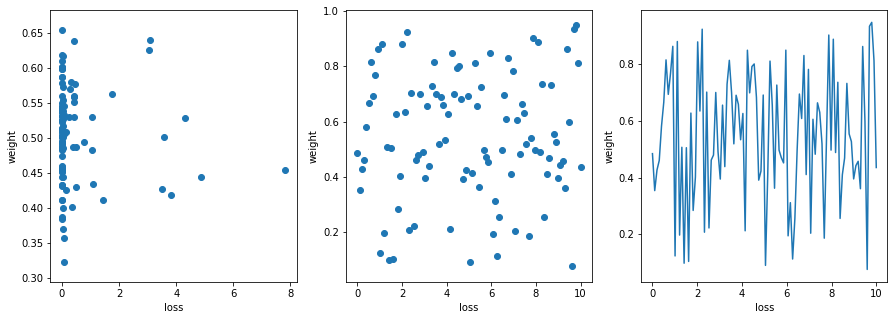

In [38]:
f, axs = plt.subplots(1,3)
f.set_size_inches((15, 5))

# plt loss-weight scatter on meta data
for i, (input, target) in enumerate(valid_loader):
    input_var = to_var(input, requires_grad=False)
    target_var = to_var(target, requires_grad=False)

    with torch.no_grad():
        y_f = model(input_var) # [100,10]
        
        _, pred = y_f.max(1)  # val,idx
        acc = pred.eq(target_var).sum().item() / 100
        print('acc:', acc)  # 
        
        cost_w = F.cross_entropy(y_f, target_var, reduction='none')
        cost_v = torch.reshape(cost_w, (1, len(cost_w)))  # [1,100] batchsize=1 for vnet

        w_new = vnet(cost_v)  # [1,100]

        meta_x, meta_y = to_numpy(cost_v), to_numpy(w_new)
        meta_x, meta_y = meta_x.squeeze(), meta_y.squeeze()
        
        ax = axs.flat[0]
        ax.set_xlabel('loss')
        ax.set_ylabel('weight')
        ax.scatter(meta_x, meta_y)

# plt vnet, 事实上 input 100 neuron loss 不可能均匀分布
from plt_vnet import get_vnet_v2_map

fake_x, fake_y = get_vnet_v2_map(vnet)
fake_x, fake_y = fake_x.squeeze(), fake_y.squeeze()

ax = axs.flat[1]
ax.set_xlabel('loss')
ax.set_ylabel('weight')
ax.scatter(fake_x, fake_y)

ax = axs.flat[2]
ax.set_xlabel('loss')
ax.set_ylabel('weight')
ax.plot(fake_x, fake_y)

plt.show()

### 实验发现
- 虽然 batch_weight 考虑了样本间关系，但 sample 和 weight 之间对应关系又变得模糊了，**同一 loss 可对应不同 weight**
- 如果 batch 输入样本 loss 顺序改变，模型输出的 weights 也不同

### find the relation between loss and weight
- sort by loss
- one loss can have multi-weights, 1-vs-n
- while original vnet one loss maps one weight, 1-vs-1

In [35]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 100

df = pd.DataFrame(zip(meta_x, meta_y), columns=['loss', 'weight'])
df.sort_values(by=['loss'])  # 0.000002 对应 3个不同 weights

,loss,weight
4,-0.000000,0.590129
67,0.000002,0.460432
29,0.000002,0.802529
22,0.000002,0.572581
96,0.000009,0.472389
41,0.000010,0.567139
86,0.000011,0.497009
45,0.000012,0.492610
83,0.000013,0.414790
52,0.000020,0.724591
